<a href="https://colab.research.google.com/github/littlejacinthe/Style_Transfer/blob/main/STN_StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip uninstall tensorflow -y

In [2]:
! pip install tensorflow-gpu==1.14.0

In [3]:
import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [4]:
import librosa
from IPython.display import Audio, display
import numpy as np
from PIL import Image

In [5]:
# Reads wav file and produces spectrum
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename) 
    max_len = fs * 10
    sig = x[:max_len]
    S = librosa.stft(sig, N_FFT) # short fourier transform produces spectrogram
    p = np.angle(S) # The counterclockwise angle from the positive real axis on the complex plane in the range (-pi, pi], with dtype as numpy.float64.
    S = np.log1p(np.abs(S[:,:430]))
    # Log1p : Return the natural logarithm of one plus the input array, element-wise.
    # Abs : Calculate the absolute value element-wise.
    return S

In [6]:
audio_path = '/content/classical_03.wav' 

spec = read_audio_spectum(audio_path) # get spectrogram

print("Input Shape: {}".format(spec.shape))

Input Shape: (1025, 430)


In [7]:
input = np.ascontiguousarray(spec.T[None,:,:]) # add one dimension for batch 

In [8]:
N_FILTERS = 4096 # number of filters
N_SAMPLES = 430 # timestamp
N_CHANNELS = 1025 # frequency 

In [11]:
with tf.Graph().as_default():
  x = tf.placeholder('float32', [1,N_SAMPLES,N_CHANNELS], name="x") # using content as input for our localization network
  
  # localization network : flatten and one dense layer
  flat = tf.compat.v1.layers.flatten(inputs=x) # flatten to prepare the input for a dense layer
  dense = tf.compat.v1.layers.dense(inputs=flat, units=3, bias_initializer=tf.constant_initializer(value=[1, 0, 0.])) 
  # use the bias initializer for the transformation:
  # identity transform [1, 0, 0]
  # Translation : [1., 0., 0.5]
  #Rotation : [0.707, -0.707, 0.]
  
  with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())

        theta = dense.eval(feed_dict={x: input}) 

In [12]:
M = np.resize(theta, (1, 2)) # theta parameters for the sampling grid

In [13]:
# create normalized 1D grid
x = np.linspace(-1, 1, N_SAMPLES)

In [14]:
# reshape to (2, x)
ones = np.ones(np.prod(x.shape))
print(ones.shape)
sampling_grid = np.vstack([x, ones]) # add 1s so [x 1]
print(sampling_grid.shape)

(430,)
(2, 430)


In [15]:
num_batch=1 

In [16]:
# repeat grid num_batch times
sampling_grid = np.resize(sampling_grid, (num_batch, 2, 1*N_SAMPLES)) # N_SAMPLES = 430
print(sampling_grid.shape)

(1, 2, 430)


In [17]:
# transform the sampling grid i.e. batch multiply
batch_grids = np.matmul(M, sampling_grid) # (1, 2) * (1, 2, 430)
print(batch_grids.shape)

# reshape to (num_batch, 1, N_SAMPLES)
batch_grids = batch_grids.reshape(1, 1, N_SAMPLES) 
batch_grids = np.moveaxis(batch_grids, 1, -1)

(1, 1, 430)


In [18]:
batch_grids = batch_grids.reshape([1, 430])

In [19]:
x_s = batch_grids

# rescale x to [0, N_SAMPLES]
x = ((x_s + 1.) * N_SAMPLES) * 0.5

In [21]:
# grab 2 nearest corner points for x_i
x0 = np.floor(x).astype(np.int64)
x1 = x0 + 1

In [22]:
# make sure it's inside range [0, N_SAMPLES] 
x0 = np.clip(x0, 0, N_SAMPLES-1)
x1 = np.clip(x1, 0, N_SAMPLES-1)

In [23]:
# look up pixel values at corner coords
Ia = input[np.arange(num_batch)[:, None], x0]
Ib = input[np.arange(num_batch)[:, None], x1]

In [24]:
Ia.shape

(1, 430, 1025)

In [25]:
# calculate deltas (weight coefficients)
wa = (x1-x) * (x1-x)
wb = (x-x0) * (x-x0)

In [27]:
# add dimension for addition
wa = np.expand_dims(wa, axis=2)
wb = np.expand_dims(wb, axis=2)

In [28]:
# compute output
out = wa*Ia + wb*Ib

In [29]:
out.shape

(1, 430, 1025)

In [30]:
print(out) 

[[[1.56355278e-01 1.70552368e-01 8.56051719e-02 ... 5.41387966e-05
   1.02325869e-04 6.63413140e-05]
  [1.60073792e-01 1.66674680e-01 7.38180097e-02 ... 4.43200640e-05
   1.04404751e-04 7.16334225e-05]
  [1.68295138e-01 1.67943435e-01 6.49051752e-02 ... 3.63890814e-05
   1.09440982e-04 7.87261735e-05]
  ...
  [1.70340651e-01 4.59463866e-01 4.17629540e-01 ... 1.71426435e-04
   8.53282801e-05 4.02618587e-05]
  [1.57653425e-01 4.09167711e-01 3.70851313e-01 ... 1.53775641e-04
   7.61644862e-05 3.77087070e-05]
  [1.50062883e-01 3.66670236e-01 3.30768845e-01 ... 1.39447079e-04
   6.85144503e-05 3.65251194e-05]]]


In [31]:
import soundfile

In [35]:
# This code is for phase reconstruction, we're just using it to check on what the STN did (transformed)
# We can just skip this

out = out.reshape(430,1025)
a = out.T
fs = 22050

p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S, dtype=np.float64)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'out.wav'
soundfile.write(OUTPUT_FILENAME, x, fs)

In [36]:
print(OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME))

out.wav


In [37]:
import matplotlib.pyplot as plt

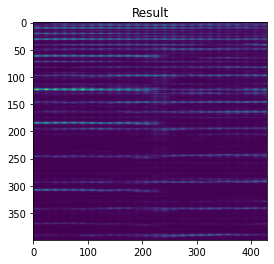

In [38]:
plt.title('STN Result')
plt.imshow(a[:400,:])
plt.show()

In [39]:
STYLE_FILENAME = "/content/jazz_05.wav"
a_style = read_audio_spectum(STYLE_FILENAME) # get style spectrogram

CONTENT_FILENAME = "/content/classical_03.wav"
a_content = read_audio_spectum(CONTENT_FILENAME) # get content spectrogram

In [66]:
N_FILTERS = 1025

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])
stn = out.reshape([1, 1, N_SAMPLES, N_CHANNELS])

# filter
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
kernel = np.random.randn(1, 1, N_CHANNELS, N_FILTERS)*std
    
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:

    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    net = tf.nn.relu(conv)

    content_features = net.eval(feed_dict={x: stn}) # feed stn as content input instead the content spectrogram
    style_features = net.eval(feed_dict={x: a_style_tf}) # feed normal spectrogram for style input
    
    features = np.reshape(style_features, (-1, N_FILTERS)) 
    style_gram = np.matmul(features.T, features) / N_SAMPLES # style gram matrix

In [67]:
from sys import stderr

ALPHA= 0.05
learning_rate= 0.01
iterations = 200

result = None

In [77]:
#kernel = np.random.randn(1, 1, N_CHANNELS, N_CHANNELS)

with tf.Graph().as_default():

    # Build graph with variable input : try with 0s, random input, content or style 
#     x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")
#    x = tf.Variable(a_style_tf, dtype=np.float32, name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    
    net = tf.nn.relu(conv)

    content_loss = ALPHA * 2 * tf.nn.l2_loss(
            net - content_features)

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape())

    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

     # Overall loss
    loss = content_loss + style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 300})
        
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
       
        print('Started optimization.')
        opt.minimize(sess)

        print('content loss', content_loss.eval())
        print('style loss', style_loss.eval())
    
        print('Final loss:', loss.eval())
        result = x.eval()

Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 269.858215
  Number of iterations: 97
  Number of functions evaluations: 114
content loss 182.21819
style loss 87.64003
Final loss: 269.85822


In [78]:
# phase reconstruction 

a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'out.wav'
soundfile.write(OUTPUT_FILENAME, x, fs)

In [79]:
print(OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME))

out.wav
